<a href="https://colab.research.google.com/github/HyeonhoonLee/OSAM_NLP/blob/master/withFastText.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. EDA

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np 
import pandas as pd
import sklearn 
from sklearn import model_selection
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

In [3]:
# randsom seed
seed=1234
np.random.seed(seed)

In [4]:
num_classes=26

In [5]:
DATA_IN_PATH = '/content/drive/My Drive/DataCollection/OSAM/'

In [6]:
print("파일 크기 : ")
for file in os.listdir(DATA_IN_PATH):
    if 'csv' in file :
        print(file.ljust(30) + str(round(os.path.getsize(DATA_IN_PATH + file) / 1000000, 2)) + 'MB')

파일 크기 : 
combined.csv                  6.62MB
combined_dup(-2000).csv       4.55MB
combined_clean(-2300).csv     4.51MB
combined_clean(6000)_sam.csv  3.98MB


In [7]:
#loading csv data
all_data = pd.read_csv(DATA_IN_PATH + 'combined_clean(6000)_sam.csv', quoting = 2)
all_data.head()

,symptom,class
0,질문하겠습니다. 이어폰을 음량을 0으로 하고 끼고만 있어도 귀에 안 좋나요?,ENT
1,독감예방주사,IP
2,목에 음식물 그대로 끼어서 계속 이물감이 있습니다,ENT
3,케겔운동 궁금한것,REHM
4,등 통증 관련문의,NS


In [8]:
# all_data의 전체 길이
len(all_data)

70249

In [9]:
# # To finding mislabelling with errata
# what = all_data.drop_duplicates("class", keep="first")
# what

In [10]:
# gotya = all_data[all_data["class"]=="UR"]
# gotya

In [11]:
#stratififed split to train_data, test_data
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

for train_idx, test_idx in split.split(all_data, all_data["class"]):
    train_data = all_data.loc[train_idx]
    test_data = all_data.loc[test_idx]

In [12]:
print('전체 학습데이터의 개수: {}'.format(len(train_data)))
print('전체 학습데이터의 개수: {}'.format(len(test_data)))

전체 학습데이터의 개수: 56199
전체 학습데이터의 개수: 14050


In [13]:
train_length = train_data['symptom'].astype(str).apply(len)

In [14]:
train_length.head()

42791    28
8836     14
17507    30
26685    10
11563    32
Name: symptom, dtype: int64

Text(0, 0.5, 'Number of symptom')

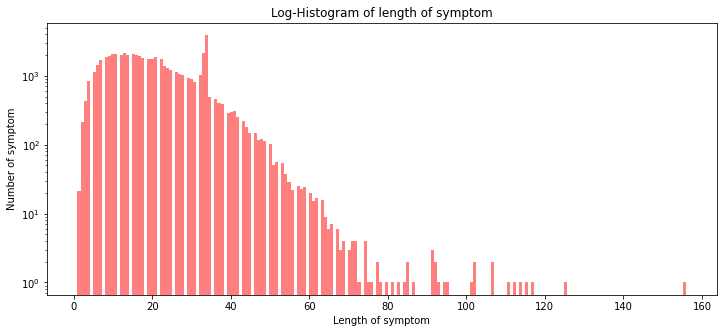

In [15]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(12, 5))
# 히스토그램 선언
# bins: 히스토그램 값들에 대한 버켓 범위
# range: x축 값의 범위
# alpha: 그래프 색상 투명도
# color: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(train_length, bins=200, alpha=0.5, color= 'r', label='word')
plt.yscale('log', nonposy='clip')
# 그래프 제목
plt.title('Log-Histogram of length of symptom')
# 그래프 x 축 라벨
plt.xlabel('Length of symptom')
# 그래프 y 축 라벨
plt.ylabel('Number of symptom')

In [16]:
print('증상 길이 최대 값: {}'.format(np.max(train_length)))
print('증상 길이 최소 값: {}'.format(np.min(train_length)))
print('증상 길이 평균 값: {:.2f}'.format(np.mean(train_length)))
print('증상 길이 표준편차: {:.2f}'.format(np.std(train_length)))
print('증상 길이 중간 값: {}'.format(np.median(train_length)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('증상 길이 제 1 사분위: {}'.format(np.percentile(train_length, 25)))
print('증상 길이 제 3 사분위: {}'.format(np.percentile(train_length, 75)))

증상 길이 최대 값: 156
증상 길이 최소 값: 1
증상 길이 평균 값: 20.42
증상 길이 표준편차: 11.03
증상 길이 중간 값: 19.0
증상 길이 제 1 사분위: 12.0
증상 길이 제 3 사분위: 29.0


{'boxes': [<matplotlib.lines.Line2D at 0x7fb84eec5f98>],
 'caps': [<matplotlib.lines.Line2D at 0x7fb84ee519e8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fb84ee5a7f0>],
 'means': [<matplotlib.lines.Line2D at 0x7fb84ee5a4a8>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb84ee5a128>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fb84ee512e8>,
  <matplotlib.lines.Line2D at 0x7fb84ee51668>]}

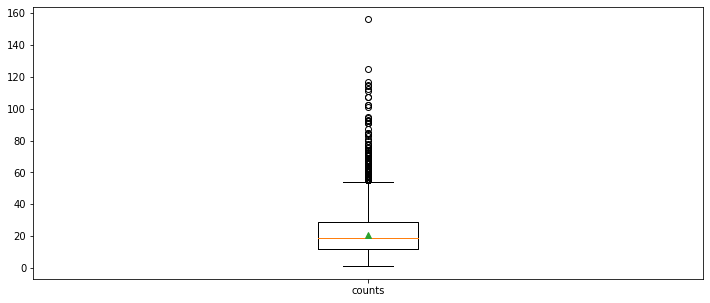

In [17]:
plt.figure(figsize=(12, 5))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를 입력
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 마크함

plt.boxplot(train_length,
             labels=['counts'],
             showmeans=True)

In [18]:
# 보통은 문자열이 아닌 데이터는 삭제하나, 증상의 경우 발열, 체중 등과 같은 내용이 중요하므로 숫자도 살려둔다.
# train_review = [review for review in train_data['document'] if type(review) is str]
train_symptom = [symptom for symptom in train_data['symptom'] if type(symptom) is (str or int or float)]

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


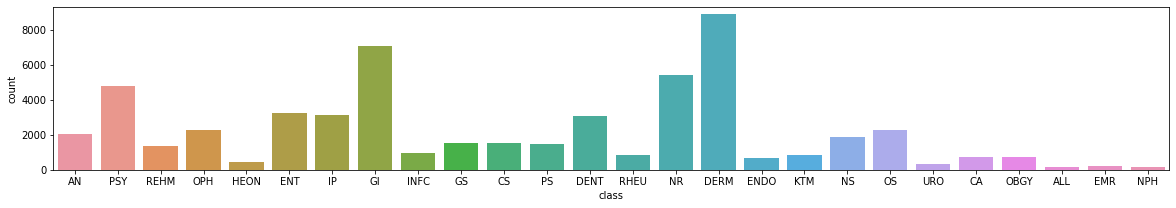

In [19]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(20, 3)
sns.countplot(train_data['class'])

In [20]:
# DERM: 피부과 / GS: 외과 / IP: 호흡기내과 / FM: 가정의학과 / GI: 소화기내과 / OPH: 안과
# NR: 신경과 / ENT: 이비인후과 / PSY : 신경정신과 / HEON: 혈액종양내과 / RHEU: 류마티스내과
# REHM: 재활의학과 / NS: 신경외과 / AN: 마취통증의학과 / DENT: 치과 / PS: 성형외과
# RAD: 영상의학과 / CS: 흉부외과 / INFC: 감염내과 / RAON: 방사선종양학과 / OS: 정형외과 
# EMR: 응급의학과 / ENDO: 내분비내과 / CA: 순환기내과 / KTM: 한방과 / OBGY: 산부인과
# URO: 비뇨기과 / ALL: 알레르기 내과 / NPH: 신장내과 / OEM:직업환경의학과 / COAN: 대장항문외과
# LAB: 진단검사의학과 

In [21]:
# convert class from string to integer
class_to_label = {'DERM': 0, 'GS': 1, 'IP': 2, 'GI':3, 'OPH':4,
                  'NR': 5, 'ENT': 6, 'PSY': 7, 'HEON': 8, 'RHEU': 9,
                  'REHM': 10, 'NS': 11, 'AN': 12, 'DENT': 13, 'PS': 14,
                  'CS': 15, 'INFC': 16, 'OS': 17,
                  'EMR': 18, 'ENDO': 19, 'CA': 20, 'KTM': 21, 'OBGY': 22,
                  'URO': 23, 'ALL': 24, 'NPH': 25}

train_data['label'] = train_data['class'].map(class_to_label)
test_data['label'] = test_data['class'].map(class_to_label)
train_data.head()

,symptom,class,label
42791,허리 아래쪽 부근이 뻐근하여 통증이 꽤 발생합니다.,AN,12
8836,정신건강 의학과 질문드려요,PSY,7
17507,목디스크가 있습니다. 계단 오르내리기 둘다 괜찮은가요?,REHM,10
26685,이거 비문증인가요?,OPH,4
11563,끔찍한 꿈을 자주 꾸는데 정신적으로 문제가 있는 걸까요..,PSY,7


In [22]:
# severe imbalenced data가 확인되지만 real-world로 반영한다고 생각하고 그대로 진행한다.
# 단, FM(가정의학과)의 비중이 너무 높고 오히려 OS 비중이 낮은 것은 본 프로젝트가 군인 대상인 점을 감안하여 조정이 필요할 것 같다.
for i in range(num_classes):
  print("증상 개수: {}".format(train_data['class'].value_counts()[i]))

증상 개수: 8887
증상 개수: 7062
증상 개수: 5436
증상 개수: 4823
증상 개수: 3278
증상 개수: 3124
증상 개수: 3085
증상 개수: 2290
증상 개수: 2260
증상 개수: 2067
증상 개수: 1852
증상 개수: 1549
증상 개수: 1529
증상 개수: 1449
증상 개수: 1383
증상 개수: 946
증상 개수: 875
증상 개수: 827
증상 개수: 741
증상 개수: 738
증상 개수: 681
증상 개수: 446
증상 개수: 322
증상 개수: 230
증상 개수: 172
증상 개수: 147


In [23]:
# 각 증상 서술의 단어 수를 확인.
# 데이터를 띄어쓰기 기준으로 나눠서 그 개수를 하나의 변수로 할당한다.
train_word_counts = train_data['symptom'].astype(str).apply(lambda x:len(x.split(' ')))

Text(0, 0.5, 'Number of symptom')

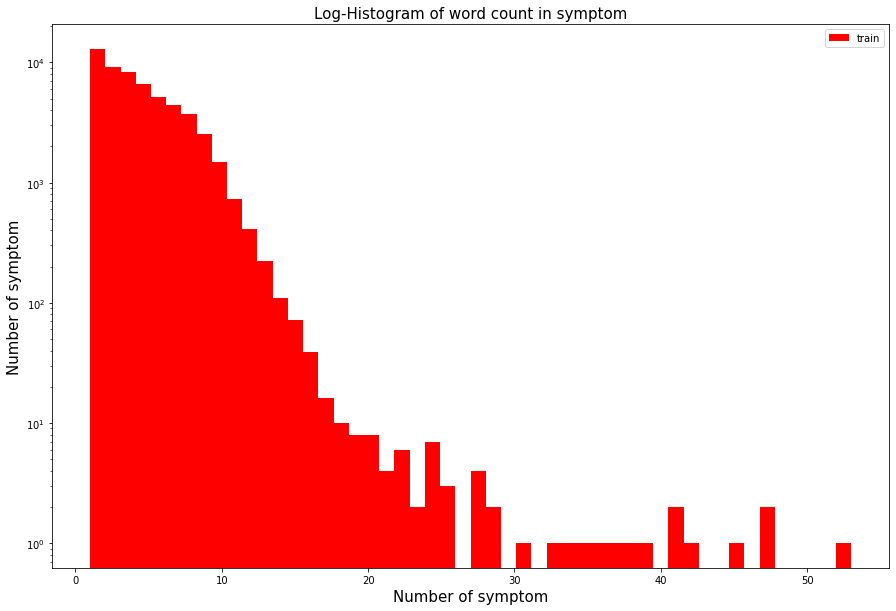

In [24]:
plt.figure(figsize=(15, 10))
plt.hist(train_word_counts, bins=50, facecolor='r',label='train')
plt.title('Log-Histogram of word count in symptom', fontsize=15)
plt.yscale('log', nonposy='clip')
plt.legend()
plt.xlabel('Number of symptom', fontsize=15)
plt.ylabel('Number of symptom', fontsize=15)

In [25]:
print('증상 단어 개수 최대 값: {}'.format(np.max(train_word_counts)))
print('증상 단어 개수 최소 값: {}'.format(np.min(train_word_counts)))
print('증상 단어 개수 평균 값: {:.2f}'.format(np.mean(train_word_counts)))
print('증상 단어 개수 표준편차: {:.2f}'.format(np.std(train_word_counts)))
print('증상 단어 개수 중간 값: {}'.format(np.median(train_word_counts)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('증상 단어 개수 제 1 사분위: {}'.format(np.percentile(train_word_counts, 25)))
print('증상 단어 개수 제 3 사분위: {}'.format(np.percentile(train_word_counts, 75)))

증상 단어 개수 최대 값: 53
증상 단어 개수 최소 값: 1
증상 단어 개수 평균 값: 4.74
증상 단어 개수 표준편차: 2.80
증상 단어 개수 중간 값: 4.0
증상 단어 개수 제 1 사분위: 3.0
증상 단어 개수 제 3 사분위: 6.0


In [26]:
# 특수문자 확인하기
qmarks = np.mean(train_data['symptom'].astype(str).apply(lambda x: '?' in x)) # 물음표가 구두점으로 쓰임
fullstop = np.mean(train_data['symptom'].astype(str).apply(lambda x: '.' in x)) # 마침표
                  
print('물음표가있는 질문: {:.2f}%'.format(qmarks * 100))
print('마침표가 있는 질문: {:.2f}%'.format(fullstop * 100))

물음표가있는 질문: 19.31%
마침표가 있는 질문: 33.46%


## 2. FastText를 이용한 fine tuning

In [27]:
import re
from tqdm import tqdm

import tensorflow as tf 

### Hyperparameters

In [28]:
#random seed 고정
tf.random.set_seed(seed)

BATCH_SIZE = 32
NUM_EPOCHS = 10
# VALID_SPLIT = 0.2   ##이미 validation split을 straitified하게 시행함.
# MAX_LEN = 30 # EDA상 3사분위 수가 word수가 7이었다. token 갯수는 대략 30으로 가정해본다.
# DATA_IN_PATH = 'data_in/KOR' ## EDA 
DATA_OUT_PATH = "/content/drive/My Drive/DataCollection/OSAM"

### Tokenizers

In [29]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [30]:
train_sentence, train_label = train_data["symptom"], train_data["label"]
test_sentence, test_label = test_data["symptom"], test_data["label"]

In [31]:
t = Tokenizer()
t.fit_on_texts(train_sentence)
# t.fit_on_texts(test_sentence)
vocab_size = len(t.word_index)+1
vocab_size

69252

In [ ]:
X_encoded = t.texts_to_sequences(train_sentence)
X_encoded

In [ ]:
t_X_encoded = t.texts_to_sequences(test_sentence)
t_X_encoded

In [34]:
max_len = max(len(i) for i in X_encoded)
max_len

28

In [35]:
X_train = pad_sequences(X_encoded, maxlen=max_len, padding='post')
Y_train = np.array(train_label)
print(X_train.shape)
Y_train.shape

(56199, 28)


(56199,)

In [36]:
X_test = pad_sequences(t_X_encoded, maxlen=max_len, padding='post')
Y_test = np.array(test_label)
print(X_test.shape)
Y_test.shape

(14050, 28)


(14050,)

### Pretrained FastText embedding for Korean

In [37]:
!pip install fasttext

     |████████████████████████████████| 71kB 3.2MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3015938 sha256=0916ad853e4c0504ad1d3454b12bff36939419487b5b10d74f91d39244994e18
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


In [38]:
import fasttext.util
fasttext.util.download_model('ko', if_exists='ignore')  # Korean
ko_model = fasttext.load_model('cc.ko.300.bin')

In [ ]:
# from gensim import models

# models.fasttext.FastText.load_fasttext_format('cc.ko.300.bin',)

In [40]:
# To get embedding matrix with FastText, we make zero matrix fisrt.
N = ko_model.get_dimension()
embedding_matrix = np.zeros((vocab_size, N))
# 단어 집합 크기의 행과 N개 열을 가지는 행렬 생성. 값은 전부 0으로 채워진다.
embedding_matrix.shape

(69252, 300)

In [ ]:
# ko_model.get_words

<bound method _FastText.get_words of <fasttext.FastText._FastText object at 0x7f07537dd908>>

In [ ]:
# def get_vector(word):
#   if word in ko_model:
#     return ko_model[word]
#   else:
#     return none

In [46]:
ko_model.get_word_vector("이비").shape

(300,)

In [47]:
for word, i in t.word_index.items(): #훈련 데이터의 단어 집합에서 단어와 정수 인덱스르 1개씩 꺼내온다.
  temp = ko_model.get_word_vector(word) #단어(key) 해당되는 임베딩 벡터의 300개의 값(value)를 임시 변수에 저장
  if temp is not None:
    embedding_matrix[i] = temp


In [48]:
embedding_matrix.shape

(69252, 300)

### LSTM model

In [49]:
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
from keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D

In [94]:
vocab_size

69252

In [108]:
# embedding_dim = 64
model = tf.keras.Sequential([
tf.keras.layers.Embedding(vocab_size, N, weights=[embedding_matrix],
              input_length=max_len, trainable=False),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(N)),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
tf.keras.layers.Dense(256, activation='relu'),
tf.keras.layers.Dense(64, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
tf.keras.layers.Dense(num_classes, activation='sigmoid')])
# model.add(e)
# model.add(bi)
# model.add(de)
# model.add(de2)

In [109]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 28, 300)           20775600  
_________________________________________________________________
bidirectional_8 (Bidirection (None, 600)               1442400   
_________________________________________________________________
dense_15 (Dense)             (None, 256)               153856    
_________________________________________________________________
dense_16 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_17 (Dense)             (None, 26)                1690      
Total params: 22,389,994
Trainable params: 1,614,394
Non-trainable params: 20,775,600
_________________________________________________________________


### Compile and training

In [110]:
# 학습 준비하기
optimizer = tf.keras.optimizers.Adam(3e-4)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

In [111]:
model_name = "tf2_FastText_symptom2class"



# overfitting을 막기 위한 earlystop 추가
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

/content/drive/My Drive/DataCollection/OSAM/tf2_FastText_symptom2class -- Folder already exists 



In [112]:
model.compile(optimizer=optimizer, loss=loss, metrics=[metric], experimental_run_tf_function=False)

In [113]:
# 학습과 eval 시작
history = model.fit(X_train, Y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(X_test, Y_test),
                    validation_steps=(len(Y_test)/BATCH_SIZE), 
                    callbacks=[cp_callback, earlystop_callback]) 

#steps_for_epoch

print(history.history)

Epoch 1/10
1753/1757 [============================>.] - ETA: 0s - loss: 2.9378 - accuracy: 0.1357
Epoch 00001: val_accuracy improved from -inf to 0.11374, saving model to /content/drive/My Drive/DataCollection/OSAM/tf2_FastText_symptom2class/weights.h5
1757/1757 [==============================] - 18s 10ms/step - loss: 2.9375 - accuracy: 0.1357 - val_loss: 2.8743 - val_accuracy: 0.1137
Epoch 2/10
1755/1757 [============================>.] - ETA: 0s - loss: 2.8438 - accuracy: 0.1753
Epoch 00002: val_accuracy improved from 0.11374 to 0.18384, saving model to /content/drive/My Drive/DataCollection/OSAM/tf2_FastText_symptom2class/weights.h5
1757/1757 [==============================] - 17s 10ms/step - loss: 2.8437 - accuracy: 0.1753 - val_loss: 2.8290 - val_accuracy: 0.1838
Epoch 3/10
1753/1757 [============================>.] - ETA: 0s - loss: 2.8074 - accuracy: 0.2233
Epoch 00003: val_accuracy improved from 0.18384 to 0.27751, saving model to /content/drive/My Drive/DataCollection/OSAM/tf2

## Testing for new sentences

In [ ]:
## To load a best weights from a saved file (.h5)  ====> for tf 2.1
# cls_model.load_weights(checkpoint_path)

## To load a model file )  ====> for tf 2.3
#new_model = tf.keras.models.load_model('my_model.h5')

In [65]:
# exchanging key and value
label_to_class = {v:k for k,v in class_to_label.items()} 
label_to_class

{0: 'DERM',
 1: 'GS',
 2: 'IP',
 3: 'GI',
 4: 'OPH',
 5: 'NR',
 6: 'ENT',
 7: 'PSY',
 8: 'HEON',
 9: 'RHEU',
 10: 'REHM',
 11: 'NS',
 12: 'AN',
 13: 'DENT',
 14: 'PS',
 15: 'CS',
 16: 'INFC',
 17: 'OS',
 18: 'EMR',
 19: 'ENDO',
 20: 'CA',
 21: 'KTM',
 22: 'OBGY',
 23: 'URO',
 24: 'ALL',
 25: 'NPH'}

In [122]:
def specialty_predict(new_sentence):
  new_encoded = t.texts_to_sequences(new_sentence)
  encoded = pad_sequences(new_encoded, maxlen=max_len, padding='post')
  y_output = model.predict(encoded)  

  y_pred = y_output[0]  # The last hidden-state is the first element of the output tuple
  y_label = y_pred.argmax()
  y_prob = y_pred[y_label] 
  y_class = label_to_class.get(y_label)  ### normalize가 필요한 것으로 생각됨. (softmax함수가 아님..)
  # # loss, acc_score = model.evaluate(encoded)
  
  # # if(y_prob > 0.5):
  print("{:.2f}% 확률로 {}과를 방문하셔야합니다.\n".format(y_prob * 100, y_class))
  # else:
    # print("증상을 좀 더 자세히 적어주세요.")

In [134]:
input_sentence = "류마티스 관절염 치료받고 싶어요"
specialty_predict(input_sentence)

100.00% 확률로 GI과를 방문하셔야합니다.



In [127]:
input_sentence = "잠이 너무 안와서 다음날 몽롱해요"
specialty_predict(input_sentence)

100.00% 확률로 PSY과를 방문하셔야합니다.



In [133]:
input_sentence = "귀에서 이명이 들리고 비염이 있어요"
specialty_predict(input_sentence)

99.98% 확률로 ENT과를 방문하셔야합니다.



In [129]:
input_sentence = "뇌경색 이후에 어떤 운동을 하는게 좋은가요"
specialty_predict(input_sentence)

100.00% 확률로 NR과를 방문하셔야합니다.



In [130]:
input_sentence = "항문 주변이 따가워요"
specialty_predict(input_sentence)

100.00% 확률로 GI과를 방문하셔야합니다.



In [135]:
input_sentence = "뒷목이 뻐근해요"
specialty_predict(input_sentence)

99.97% 확률로 OS과를 방문하셔야합니다.



In [132]:
# 2000개까지 정리: val_acc = 0.6608
# 20571개까지 정리: val_acc = 0.6671

In [ ]:
 # keras 2.1의 predict나 evaluate에 문제가 있거나..아니면 데이터 부족의 문제인듯.
# 아무리 심한 Overfit이라고해도 acc 0.00은...
## 어떤 sentence를 입력해도 5번 신경과나 나옴... 어떻게 학습되냐에 따라 과가 결정되어져 버림..

#   # w_count= {}
  # # for lb in y_label:
  # #     try: w_count[lb]+= 1
  # #     except: w_count[lb]=1
  # # print(w_count)

In [ ]:
#imbalanced data... focal loss OR weighted cross entropy OR class_weight arguement in model.fit.   
## focal loss: https://3months.tistory.com/414